In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML
from joblib import Parallel, delayed
from tqdm import tqdm

from modules.config import DPI, FIG_SIZE
from modules.dla_algorithm import Diffusion, compare_omegas, plot_omega_comparison, COLORS_DLA

# Test various $\eta$
We test 3 values of $\eta,0,1,2$ run $200$ growth iterations and the default value of $\omega = 1.8$.

We plot the resulting cluster and concentration of the grid cells.

In [ ]:
grid_size = 100
growth_iterations = 200


def run_simulation_and_plot(eta):
    diffusion = Diffusion(grid_size, eta, initial_point="bottom")
    diffusion.run_simulation(growth_iterations)
    diffusion.plot(eta, save=True, filename=f"results/diffusion_eta_{eta}_200.png")


_ = Parallel(n_jobs=-2)(delayed(run_simulation_and_plot)(eta) for eta in [0, 1, 2]);

Figure(640x480)
Figure(640x480)
Figure(640x480)


<img src="results/diffusion_eta_0_200.png" width="333"/>
<img src="results/diffusion_eta_1_200.png" width="333"/>
<img src="results/diffusion_eta_2_200.png" width="333"/>

## Find optimal value of $\omega$
Next, we try find the approximate optimal value of $\omega$ for the three values of $\eta = 0,1,2$.

We start with initial guess of $\omega = 1.4, 1.6, 1.8, 1.9$ and run $20$ simulations with $50$ growth iterations for each combination of $\omega$ and $\eta$.

During each growth step, we solve the Lapsal equation using the **SOR** method and we check the number of iterations we had to do for **SOR** to converge. We then measure the performance of each $\omega$ by checking the total number of iterations we had to do in SOR and plot the results.

In [6]:
omegas = [1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9]
num_simulations = 100

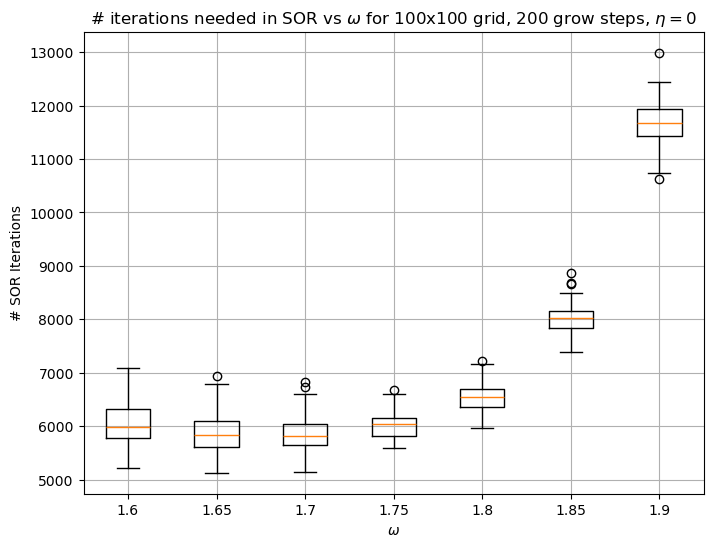

In [7]:
eta = 0

results_omegas_eta_0 = compare_omegas(eta, omegas, num_simulations)
plot_omega_comparison(
    results_omegas_eta_0,
    omegas,
    eta,
    save=True,
    filename="results/omega_comparison_eta_0.png",
)

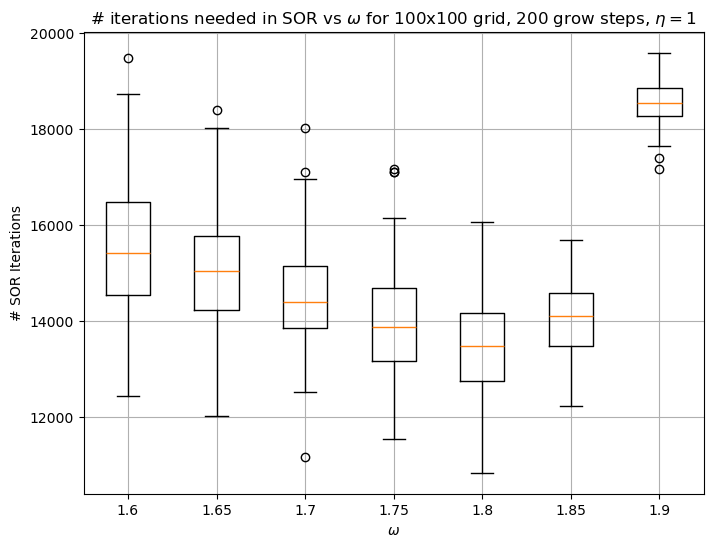

In [8]:
eta = 1

results_omegas_eta_1 = compare_omegas(eta, omegas, num_simulations)
plot_omega_comparison(
    results_omegas_eta_1,
    omegas,
    eta,
    save=True,
    filename="results/omega_comparison_eta_1.png",
)

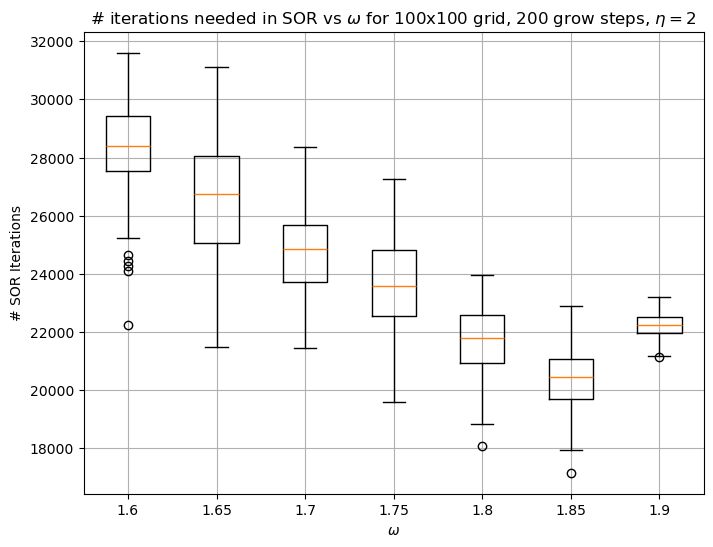

In [9]:
eta = 2

results_omegas_eta_2 = compare_omegas(eta, omegas, num_simulations)
plot_omega_comparison(
    results_omegas_eta_2,
    omegas,
    eta,
    save=True,
    filename="results/omega_comparison_eta_2.png",
)

We consolidate the results for all three in one graph by plotting the mean and standard deviation.

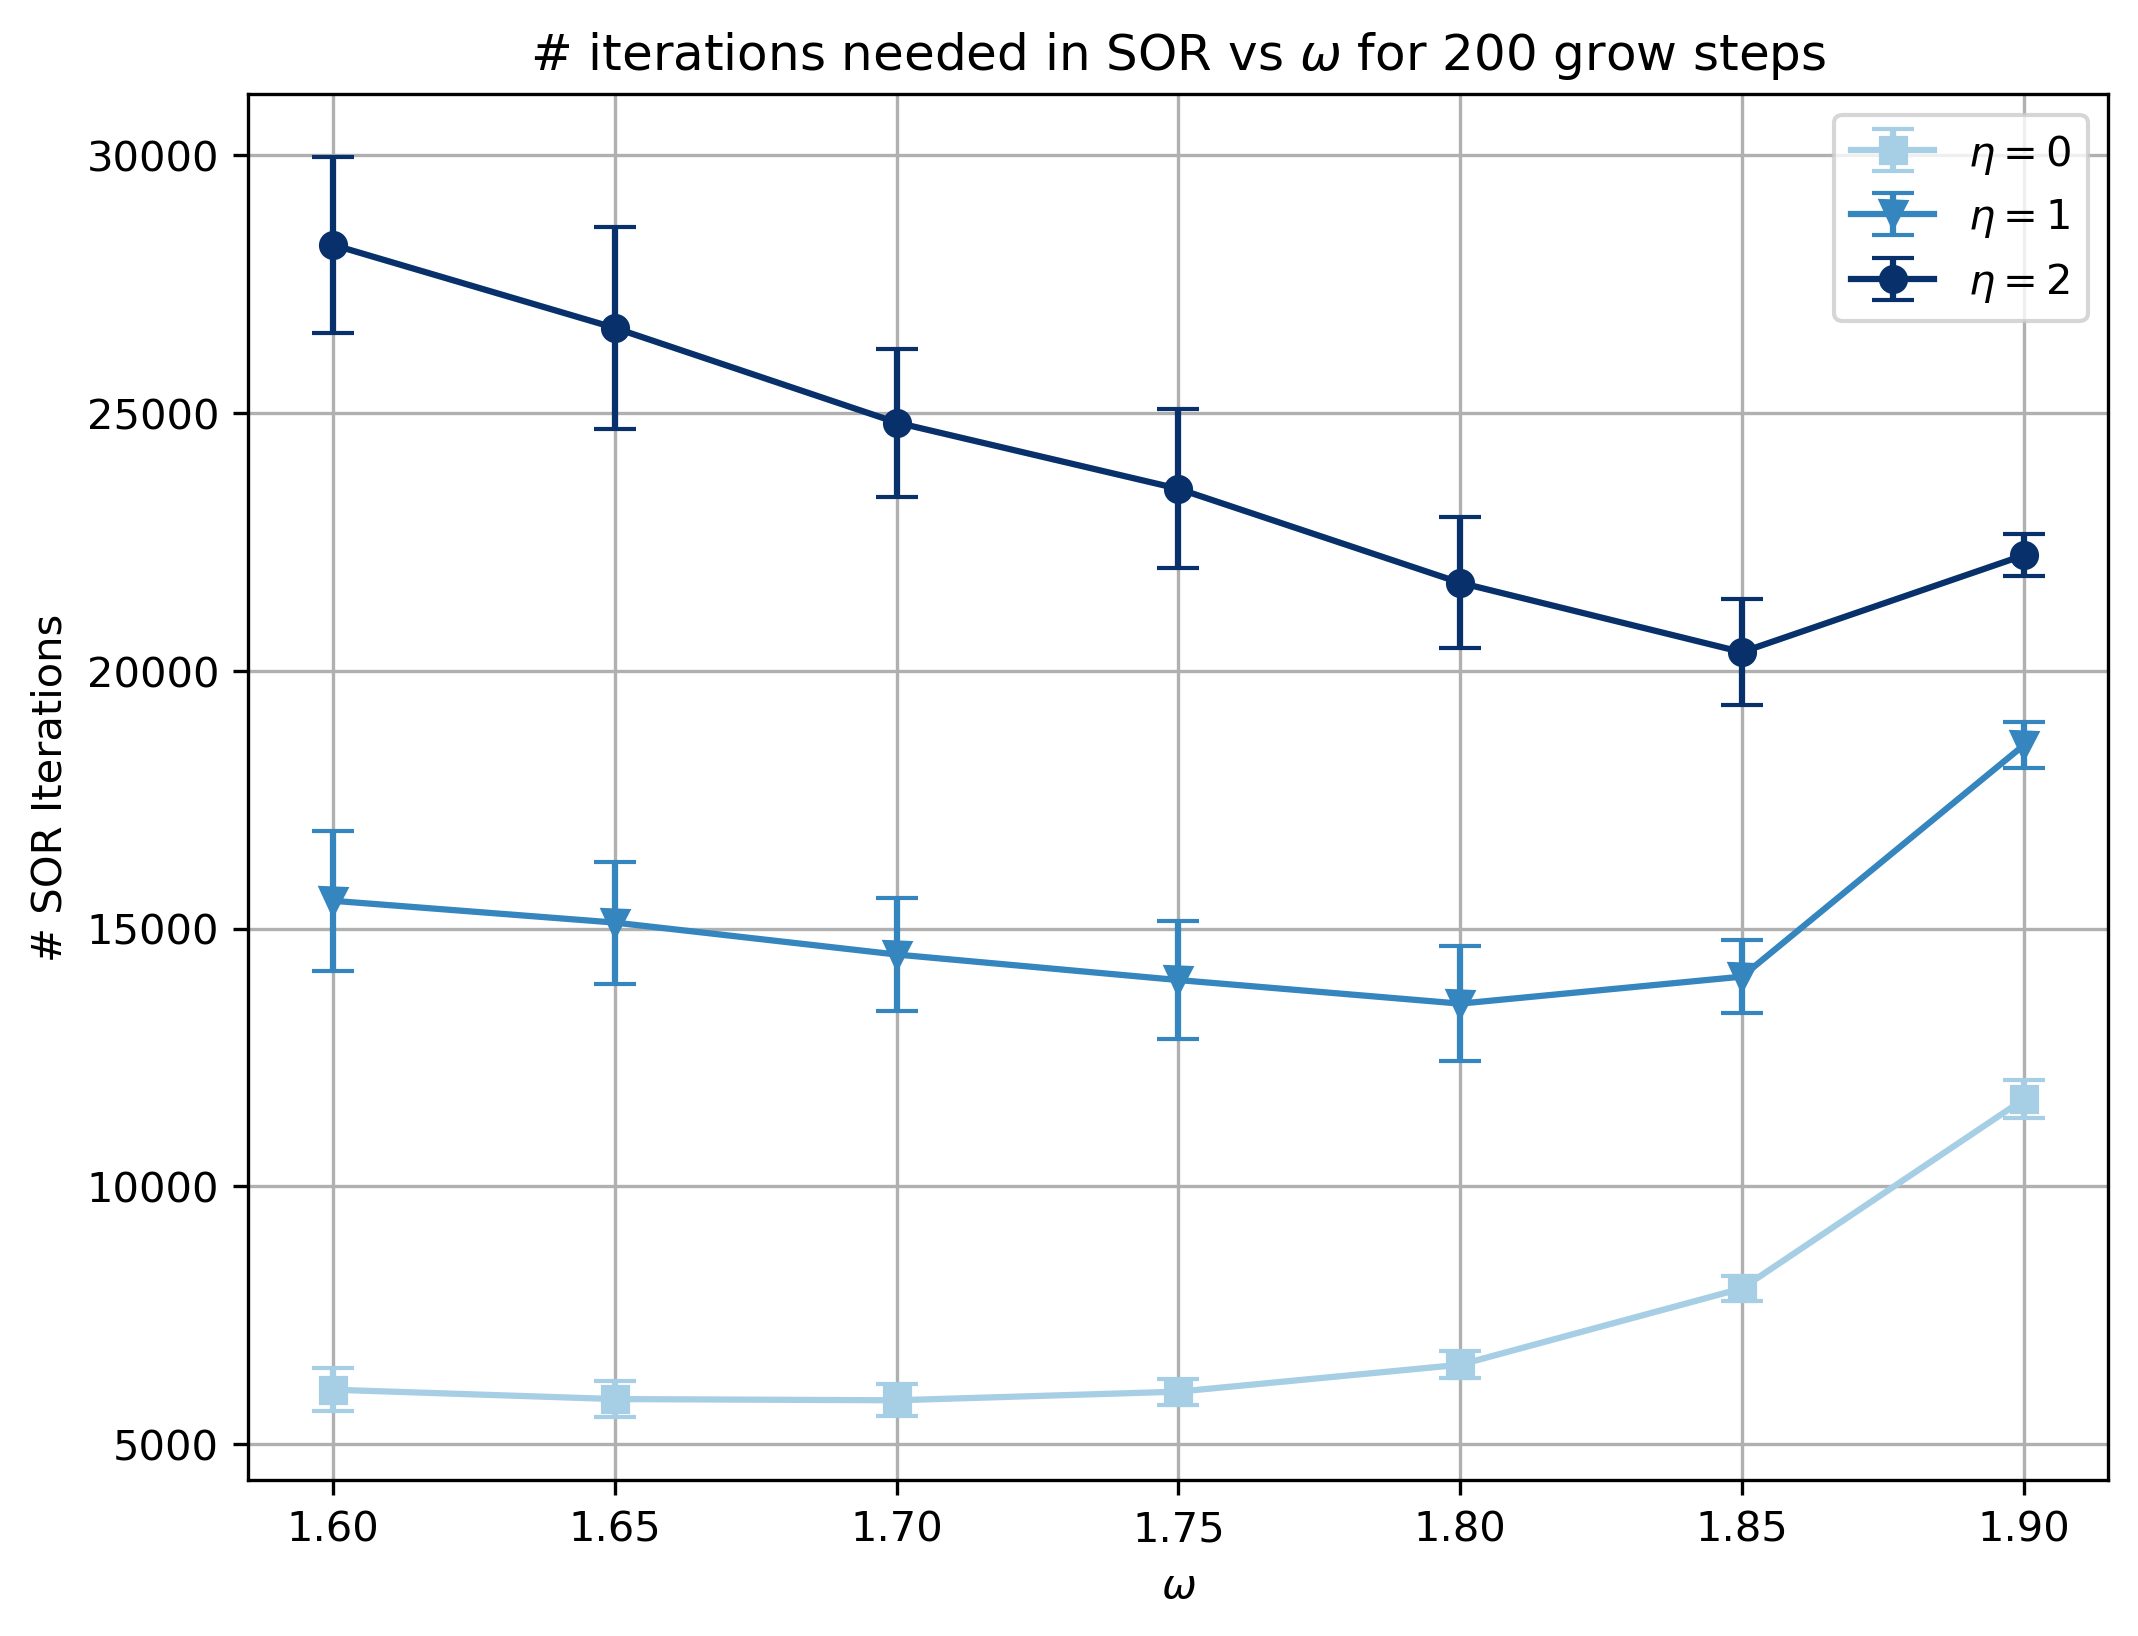

In [10]:
means_0 = np.mean(np.array(results_omegas_eta_0), axis=0)
stds_0 = np.std(np.array(results_omegas_eta_0), axis=0)

means_1 = np.mean(np.array(results_omegas_eta_1), axis=0)
stds_1 = np.std(np.array(results_omegas_eta_1), axis=0)

means_2 = np.mean(np.array(results_omegas_eta_2), axis=0)
stds_2 = np.std(np.array(results_omegas_eta_2), axis=0)

plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.errorbar(omegas, means_0, yerr=stds_0, fmt="s-", capsize=5, label=r"$\eta = 0$", color=COLORS_DLA[0])
plt.errorbar(omegas, means_1, yerr=stds_1, fmt="v-", capsize=5, label=r"$\eta = 1$", color=COLORS_DLA[1])
plt.errorbar(omegas, means_2, yerr=stds_2, fmt="o-", capsize=5, label=r"$\eta = 2$", color=COLORS_DLA[2])
plt.xlabel(r"$\omega$")
plt.ylabel("# SOR Iterations")
plt.title(r"# iterations needed in SOR vs $\omega$ for 200 grow steps")
plt.legend()
plt.grid(True)
plt.savefig("results/omega_vs_sor_mean.png", dpi=DPI, bbox_inches="tight")
plt.show()

## Analysing the cluster shape
Lastly, we analyse the shape of the cluster so that we can compare it to the Monte Carlo simulation.

We take $10$ values of $\eta$ from $0$ to $3$ and more or less optimal $\omega$ for each. We run $100$ simulations with $200$ growth iterations each and measure the size of the perimeter and the width and height of the cluster. We then plot our results.

In [11]:
grid_size = 100
growth_iterations = 200
num_simulations = 100
etas = np.linspace(0, 3, 10)
omegas = np.linspace(1.65, 1.85, 10)


def run_simulation_and_measure(eta, omega):
    diffusion = Diffusion(grid_size, eta, initial_point="bottom")
    diffusion.run_simulation(growth_iterations, omega)

    return [
        diffusion.get_perimeter_size(),
        diffusion.get_width(),
        diffusion.get_height(),
    ]

clusters = [[] for _ in range(len(etas))]

for i, eta in enumerate(etas):
    clusters[i] = np.array(
        Parallel(n_jobs=-2)(
            delayed(run_simulation_and_measure)(eta, omegas[i])
            for _ in range(num_simulations)
        )
    )

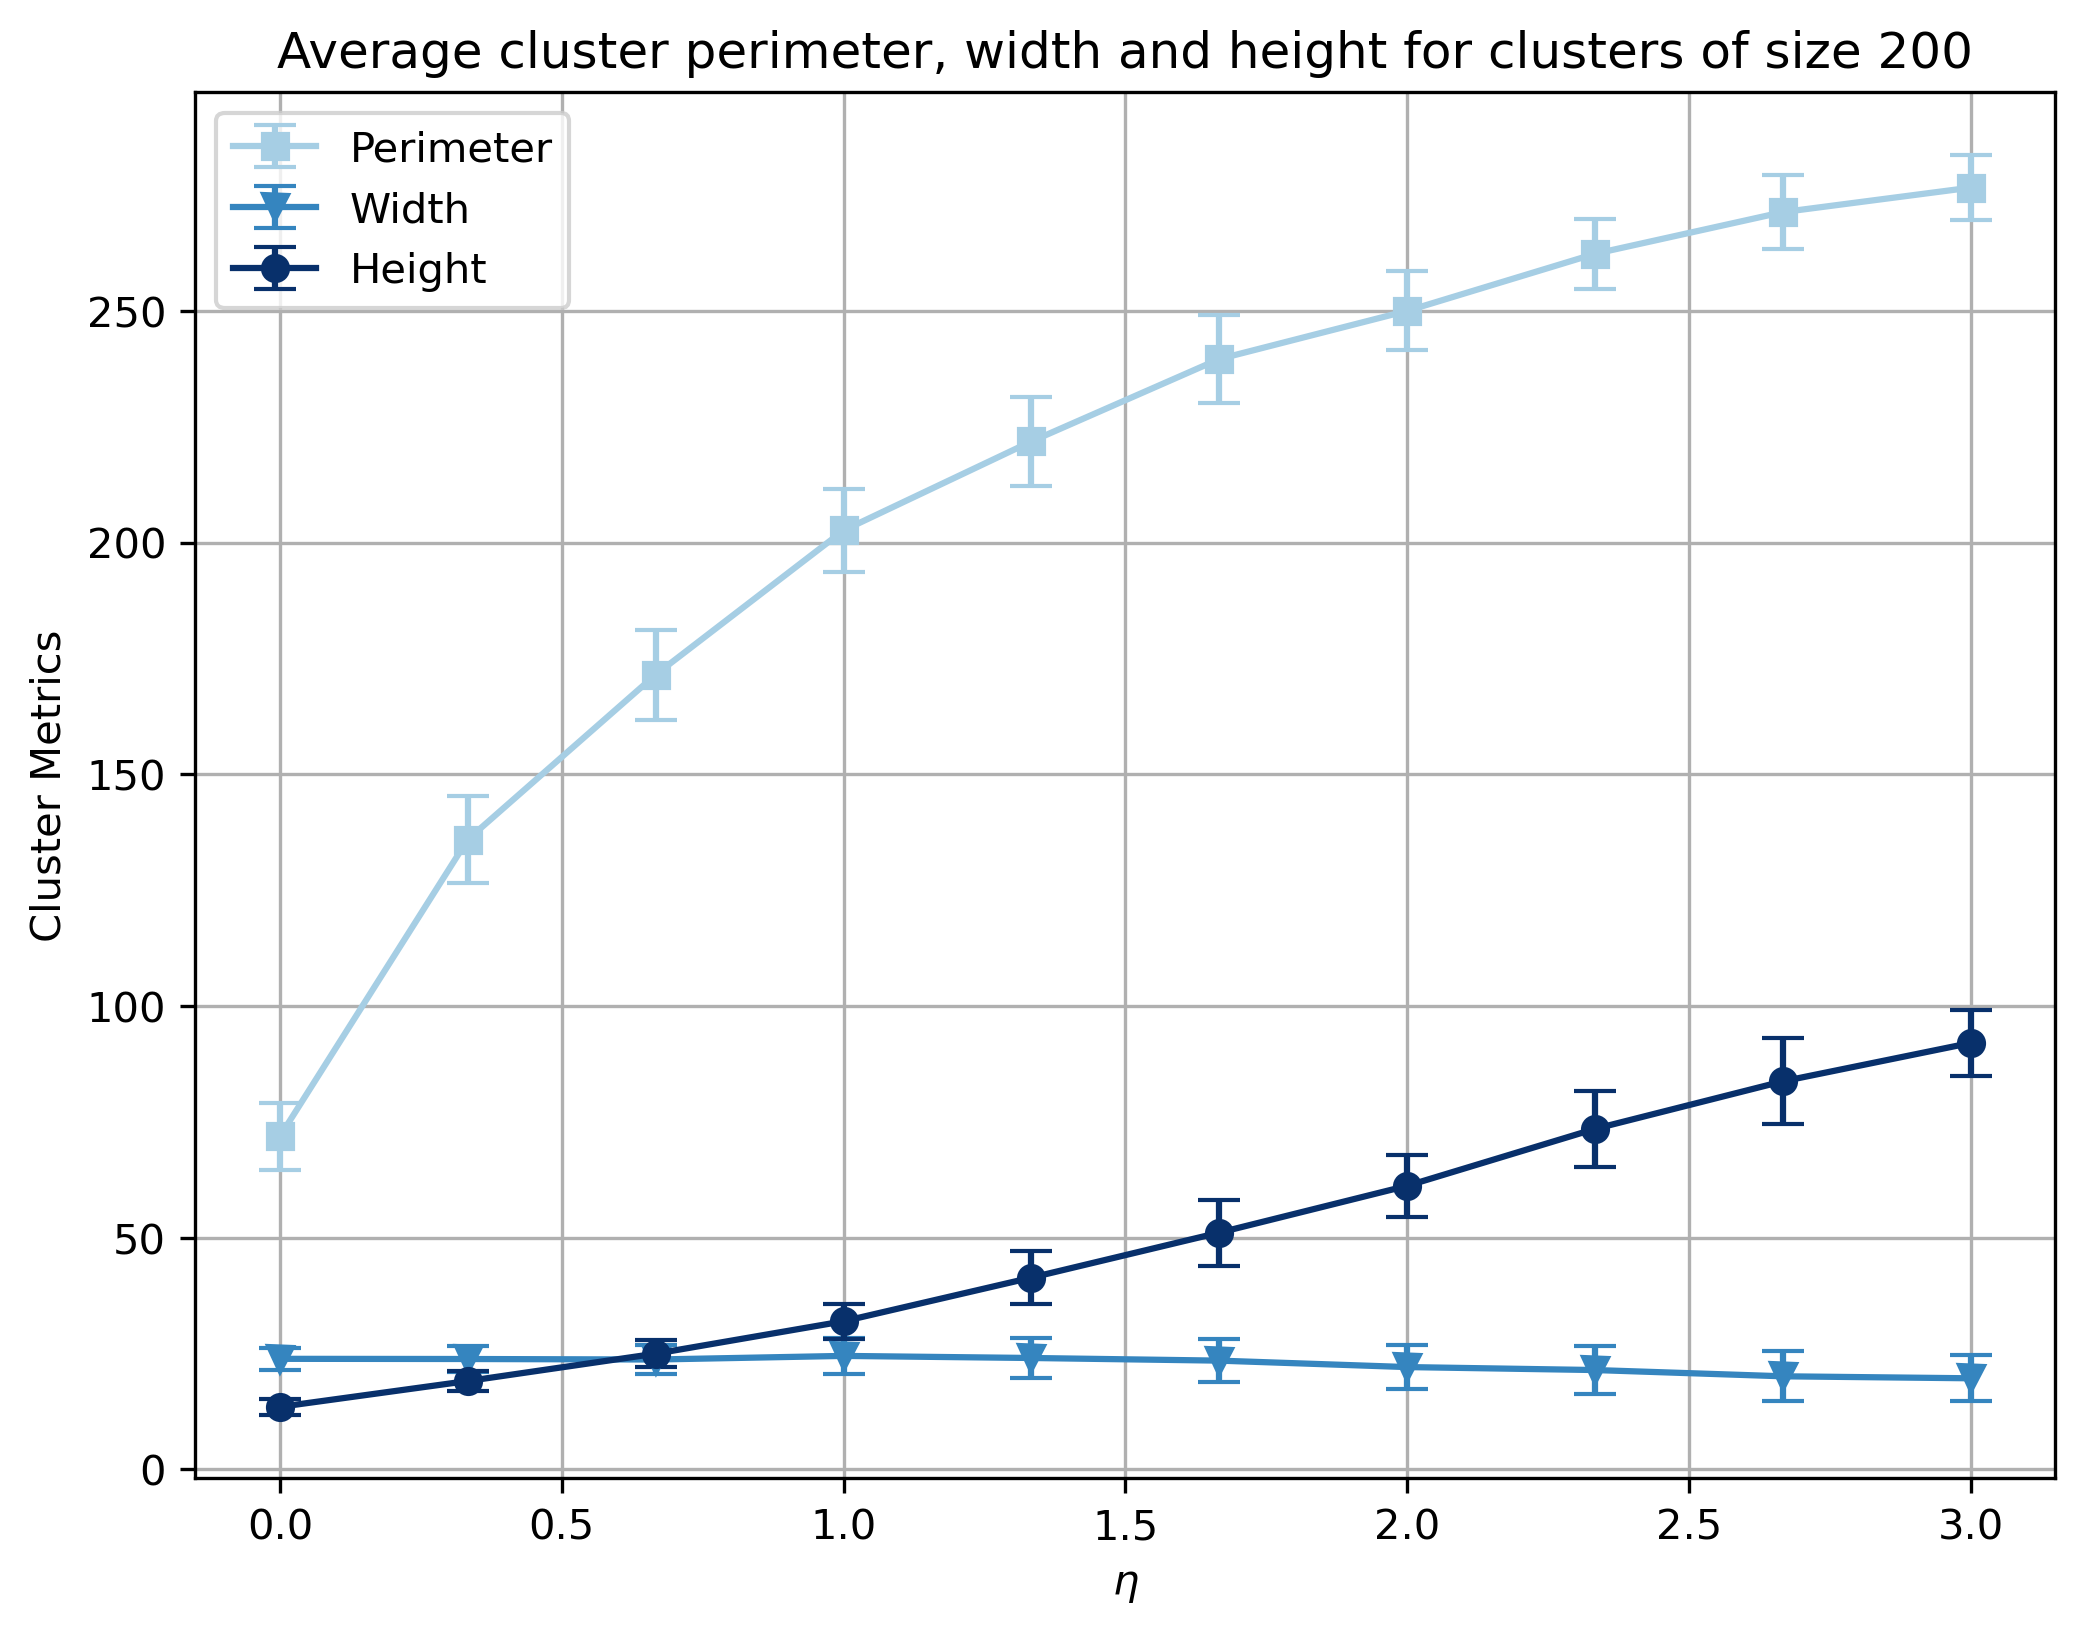

In [12]:
perimeters = [cluster_eta[:, 0] for cluster_eta in clusters]
widths = [cluster_eta[:, 1] for cluster_eta in clusters]
heights = [cluster_eta[:, 2] for cluster_eta in clusters]

means_perimeter = np.mean(perimeters, axis=1)
stds_perimeter = np.std(perimeters, axis=1)

means_width = np.mean(widths, axis=1)
stds_width = np.std(widths, axis=1)

means_height = np.mean(heights, axis=1)
stds_height = np.std(heights, axis=1)

plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.errorbar(
    etas, means_perimeter, yerr=stds_perimeter, fmt="s-", capsize=5, label="Perimeter", color=COLORS_DLA[0]
)
plt.errorbar(etas, means_width, yerr=stds_width, fmt="v-", capsize=5, label="Width", color=COLORS_DLA[1])
plt.errorbar(etas, means_height, yerr=stds_height, fmt="o-", capsize=5, label="Height", color=COLORS_DLA[2])
plt.xlabel(r"$\eta$")
plt.ylabel("Cluster Metrics")
plt.title(r"Average cluster perimeter, width and height for clusters of size 200")
plt.legend()
plt.grid(True)
plt.savefig("results/average_dla_cluster_sizes.png", dpi=DPI, bbox_inches="tight")
plt.show()

## Monte-Carlo Random Walker

For the Monte Carlo Random Walker system, we will be testing under the same conditions ast the DLA, where possible. The one parameter which can be varied, namely $p_{stick}$, will be tested for [0.25, 0.5, 0.75, 1]. Similarly, we will be investigating the height, width, and perimeter of the resulting clusters. 

Disclaimer: generating the results may take up to 1 hour. 

In [13]:
from modules.random_walk_monte_carlo import RandomWalker

In [14]:
grid_size = 100
steps = 10000000
num_simulations = 20
p_stick_values = [0.25, 0.5, 0.75, 1]


def run_single_simulation(p_stick, steps, grid_size):
    simulation = RandomWalker(N=grid_size, p_stick=p_stick, initial_point="bottom")
    simulation.run_simulation(steps)
    return (
        simulation,
        len(simulation.cluster),
        simulation.get_perimeter_size(),
        simulation.get_width(),
        simulation.get_height(),
    )


results = []
final_simulations = {}

for p_stick in p_stick_values:
    cluster_sizes, perimeter_sizes, widths, heights = [], [], [], []

    for _ in tqdm(
        range(num_simulations), desc=f"Running p_stick={p_stick}", leave=True
    ):
        simulation, cluster_size, perimeter_size, width, height = run_single_simulation(
            p_stick, steps, grid_size
        )

        cluster_sizes.append(cluster_size)
        perimeter_sizes.append(perimeter_size)
        widths.append(width)
        heights.append(height)

    final_simulations[p_stick] = simulation

    results.append(
        {
            "p_stick": p_stick,
            "mean_cluster_size": np.mean(cluster_sizes),
            "std_cluster_size": np.std(cluster_sizes),
            "mean_perimeter_size": np.mean(perimeter_sizes),
            "std_perimeter_size": np.std(perimeter_sizes),
            "mean_width": np.mean(widths),
            "std_width": np.std(widths),
            "mean_height": np.mean(heights),
            "std_height": np.std(heights),
        }
    )

df = pd.DataFrame(results)
df.to_csv("data/random_walk_results.csv", index=False)

Running p_stick=1: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


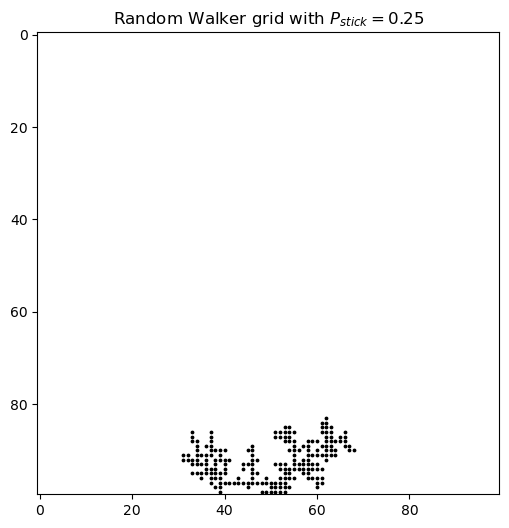

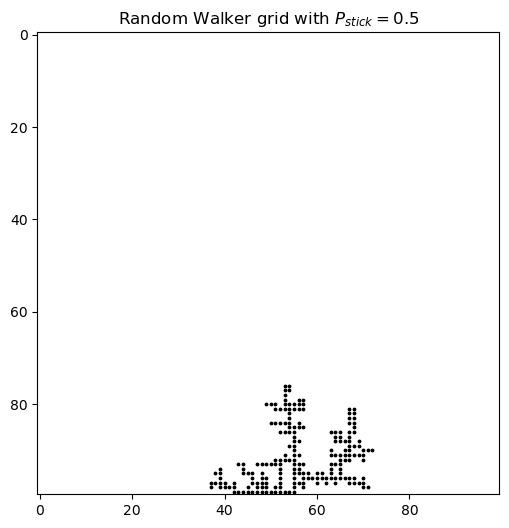

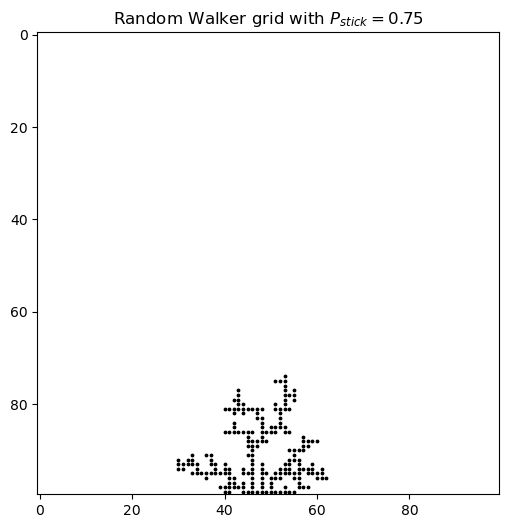

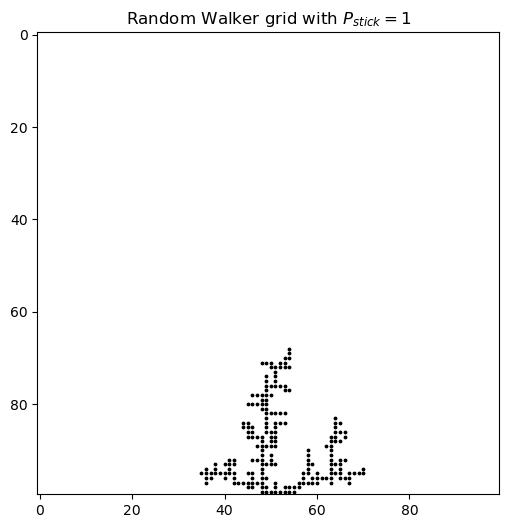

In [15]:
for p_stick, simulation in final_simulations.items():
    fig, ax = plt.subplots(figsize=(6, 6))

    im = ax.imshow(np.zeros((100, 100)), cmap="Blues", alpha=0.0)

    x_points = [coords[1] for coords in simulation.cluster]
    y_points = [coords[0] for coords in simulation.cluster]
    ax.scatter(x_points, y_points, color="black", s=3)
    ax.set_title(r"Random Walker grid with $P_{stick} = $" + f"{p_stick}")

    plt.savefig(f"results/cluster_pstick_{p_stick}.png", dpi=DPI, bbox_inches="tight")
    plt.show()

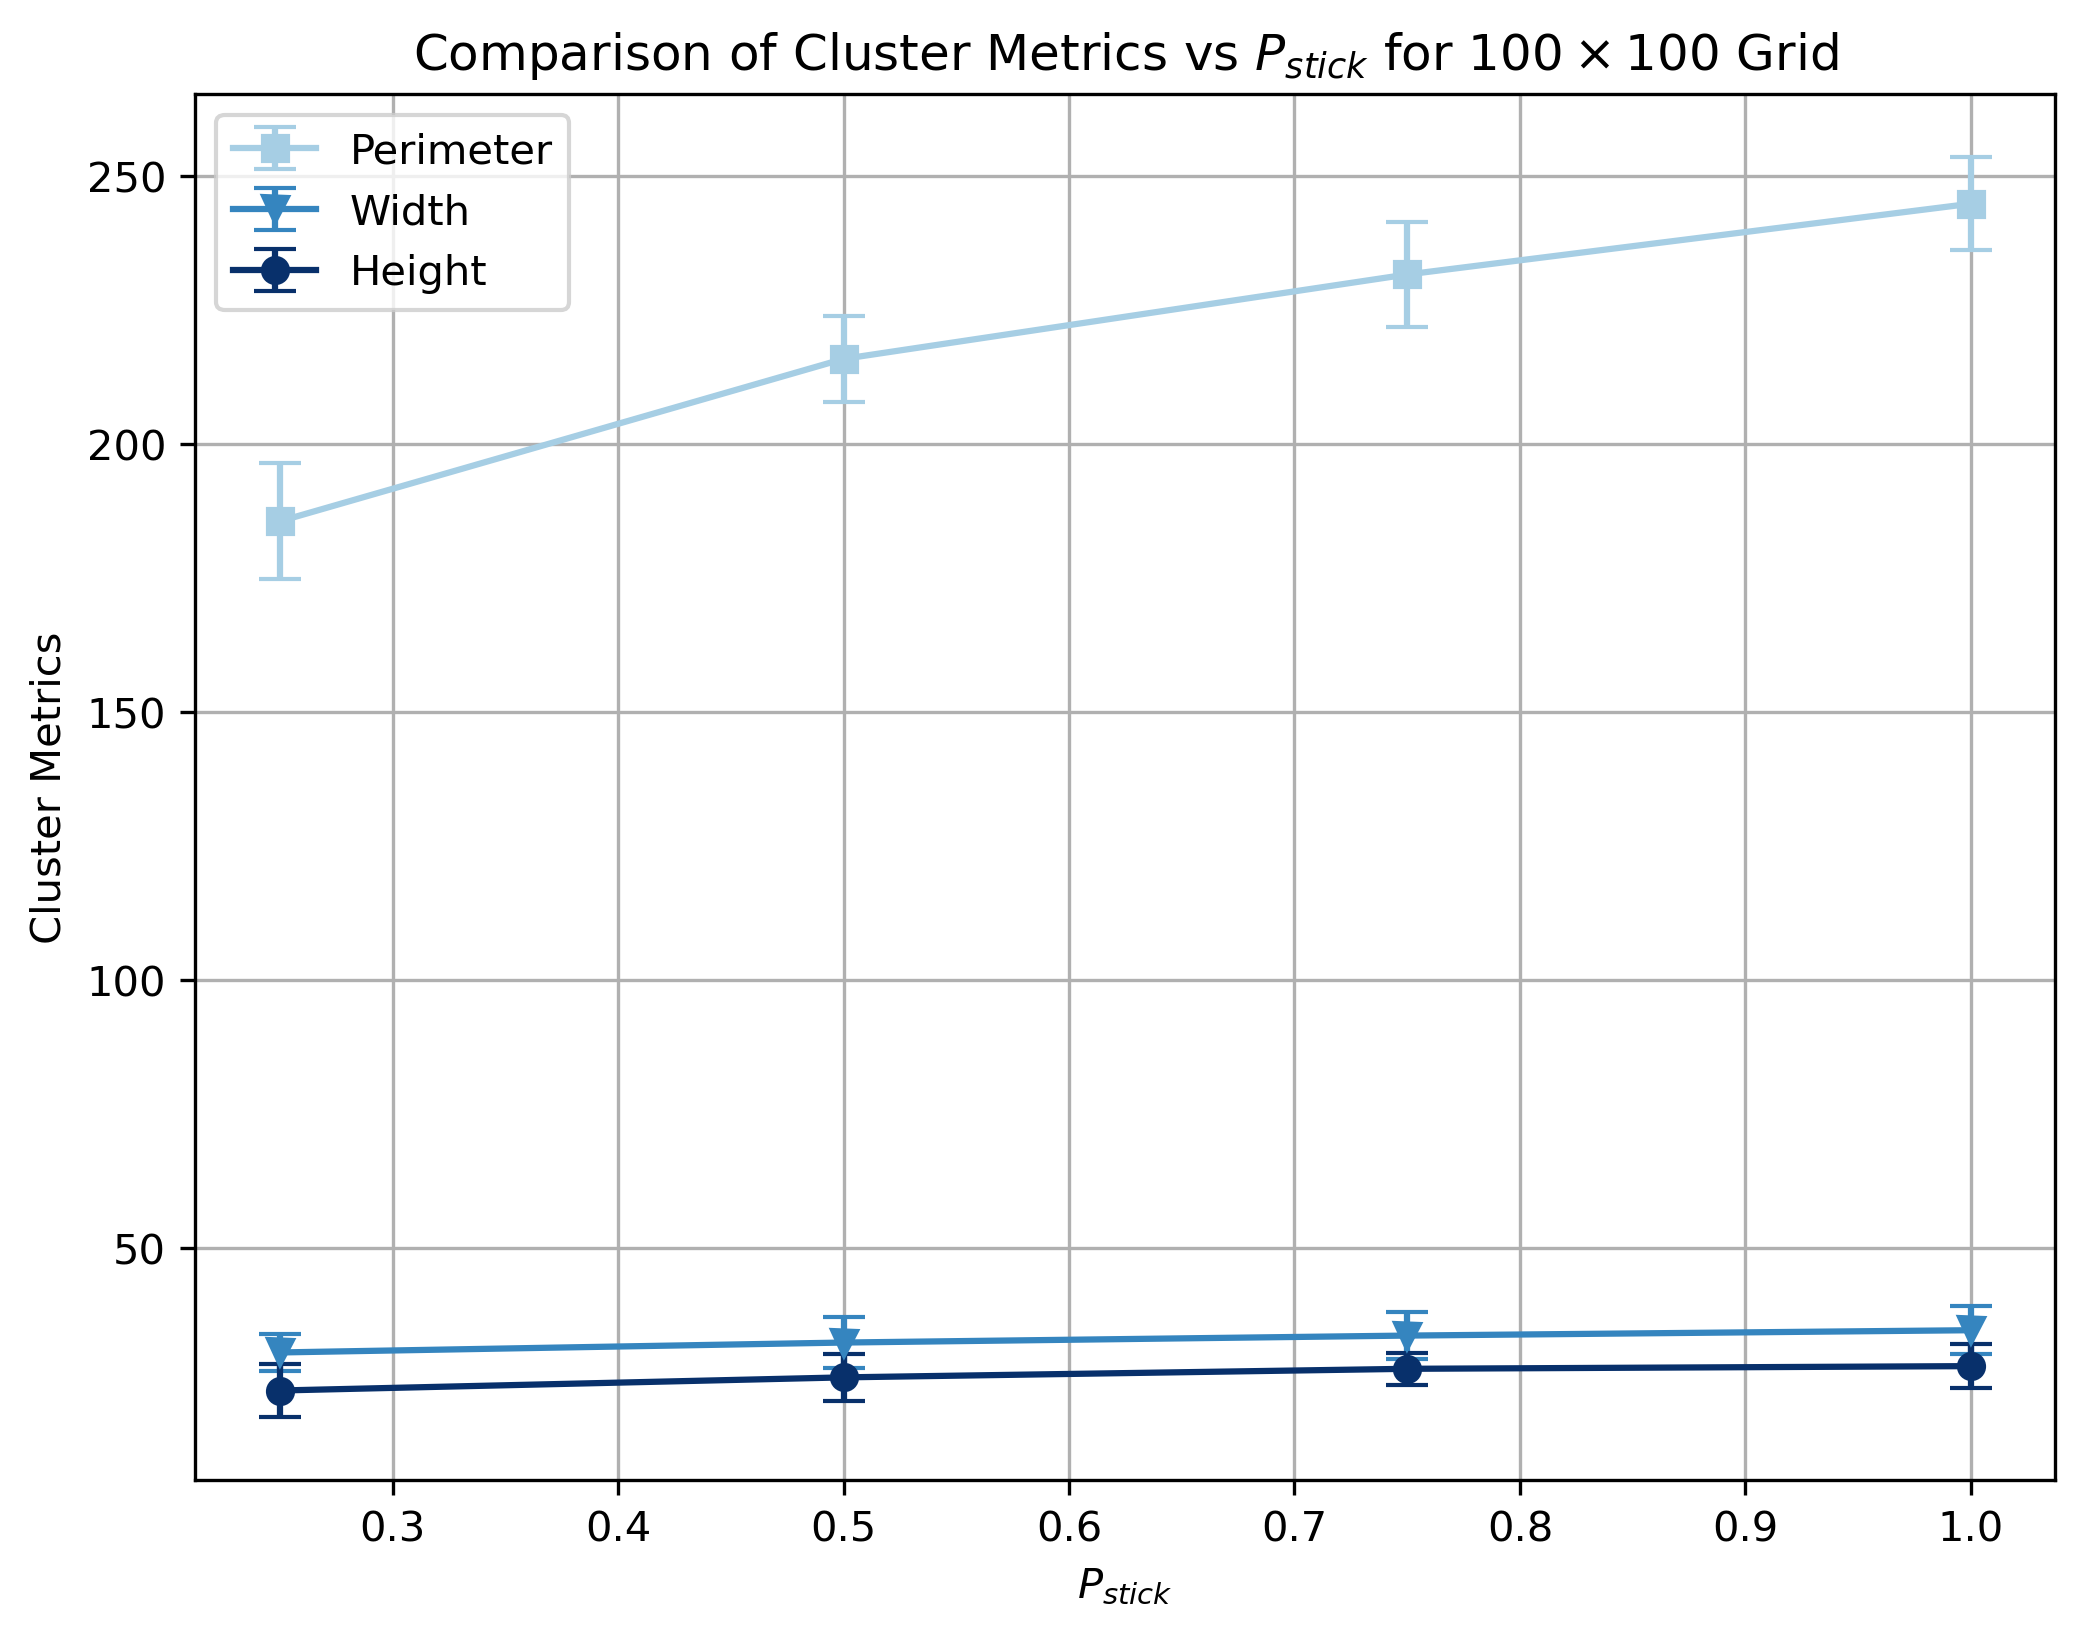

In [16]:
p_stick_values = df["p_stick"].values


mean_cluster_sizes = df["mean_cluster_size"].values
std_cluster_sizes = df["std_cluster_size"].values

mean_perimeter_sizes = df["mean_perimeter_size"].values
std_perimeter_sizes = df["std_perimeter_size"].values

mean_widths = df["mean_width"].values
std_widths = df["std_width"].values

mean_heights = df["mean_height"].values
std_heights = df["std_height"].values


plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.errorbar(
    p_stick_values,
    mean_perimeter_sizes,
    yerr=std_perimeter_sizes,
    fmt="s-",
    capsize=5,
    label=r"Perimeter",
    color=COLORS_DLA[0],
)
plt.errorbar(
    p_stick_values,
    mean_widths,
    yerr=std_widths,
    fmt="v-",
    capsize=5,
    label=r"Width",
    color=COLORS_DLA[1],
)
plt.errorbar(
    p_stick_values,
    mean_heights,
    yerr=std_heights,
    fmt="o-",
    capsize=5,
    label=r"Height",
    color=COLORS_DLA[2],
)

plt.xlabel(r"$P_{stick}$")
plt.ylabel("Cluster Metrics")
plt.title(r"Comparison of Cluster Metrics vs $P_{stick}$ for $100 \times 100$ Grid")
plt.legend()
plt.grid(True)
plt.savefig("results/RW_cluster_metrics.png", dpi=DPI, bbox_inches="tight")

plt.show()

-------
# Chemical Reaction Diffusion

Multiple parameter conditions of the Gray-Scott model are being showed. To add a new pattern, one should add a new row to the `reaction_diffusion_params` dict.

Note this script autodelets image files from the results folder.
If you want to manualy delete these images, just remove the `delete_images()` function.

The created gifs are being showed using inbeded HTML.

In [17]:
from modules.gray_scott import create_gif, delete_images, simulate_gray_scott

In [18]:
N = 100
steps = 5_000
dx = 1
dt = 1

reaction_diffusion_params = {
    "snowflake": {"Du": 0.16, "Dv": 0.08, "F": 0.035, "k": 0.06},
    "spots": {"Du": 0.1, "Dv": 0.05, "F": 0.035, "k": 0.065},
    "star": {"Du": 0.16, "Dv": 0.08, "F": 0.022, "k": 0.051},
    "wave": {"Du": 0.12, "Dv": 0.08, "F": 0.018, "k": 0.051},
}
categories = list(reaction_diffusion_params.keys())

delete_images("results")

To add noise to the system, set the `noise_u` or `noise_v` param to `True`. It is also possible to plot the other chemical, but not both of them. This is because a similar image would be visable in the plot.

The gifs can be slowed by increasing the duration param of the `create_gif()` function.

In [19]:
for category, params in reaction_diffusion_params.items():
    Du = params["Du"]
    Dv = params["Dv"]
    F = params["F"]
    k = params["k"]
    simulate_gray_scott(
        N,
        Du,
        Dv,
        F,
        k,
        dx,
        dt,
        steps,
        chemical="v",
        boundary="neumann",
        info=False,
        noise_u=False,
        noise_v=False,
    )
    gif_name = f"results/gray_scott_{category}.gif"
    create_gif("results", gif_name)
    delete_images("results")

Gray-Scott simulation: 100%|██████████| 5000/5000 [00:18<00:00, 264.57it/s]


Deleted 50 images from results


Gray-Scott simulation: 100%|██████████| 5000/5000 [00:11<00:00, 423.61it/s]


Deleted 50 images from results


Gray-Scott simulation: 100%|██████████| 5000/5000 [00:11<00:00, 436.56it/s]


Deleted 50 images from results


Gray-Scott simulation: 100%|██████████| 5000/5000 [00:12<00:00, 392.85it/s]


Deleted 50 images from results


In [20]:
HTML(f'<img src="results/gray_scott_{categories[0]}.gif">')

In [21]:
HTML(f'<img src="results/gray_scott_{categories[1]}.gif">')

In [22]:
HTML(f'<img src="results/gray_scott_{categories[2]}.gif">')

In [23]:
HTML(f'<img src="results/gray_scott_{categories[3]}.gif">')